In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('heart_data/processed.cleveland.data')
data['ca'] = pd.to_numeric(data['ca'], errors='coerce')
data['thal'] = pd.to_numeric(data['thal'], errors='coerce')
data = data.dropna()

predictors = data.drop("target",axis=1)
target = data["target"].replace([2,3,4], 1)
X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
search_space = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

In [4]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(knn, search_space, cv=5, verbose=0)
best_model = clf.fit(X_train, Y_train)

In [5]:
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', best_model.best_estimator_.get_params()['weights'])
print('Best metric:', best_model.best_estimator_.get_params()['metric'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])

Best n_neighbors: 3
Best weights: uniform
Best metric: manhattan
Best algorithm: auto


In [6]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model.best_estimator_, X_train, Y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=[np.linspace(0.02, 1.0, 50)], verbose=0, random_state=42)

In [7]:
print(test_scores.max())

0.8085106382978723


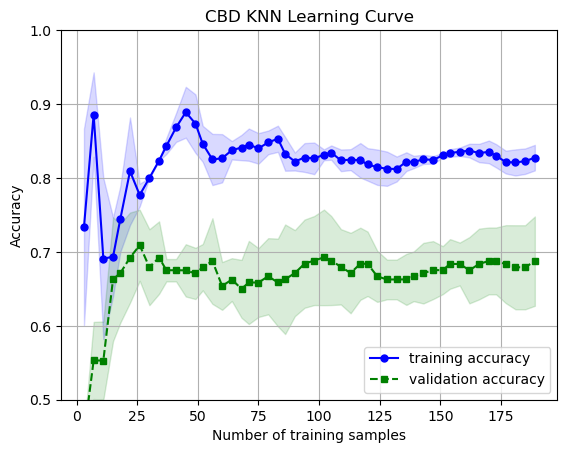

In [14]:
import matplotlib.pyplot as plt

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('CBD KNN Learning Curve')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.show()

In [22]:
from sklearn.model_selection import validation_curve

param_range = [1,2, 3, 4, 5, 6, 7, 8, 9, 10]
val_train_scores, val_test_scores = validation_curve(best_model.best_estimator_, X_train, Y_train, param_name='n_neighbors', param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_mean = np.mean(val_train_scores, axis=1)
train_std = np.std(val_train_scores, axis=1)
test_mean = np.mean(val_test_scores, axis=1)
test_std = np.std(val_test_scores, axis=1)

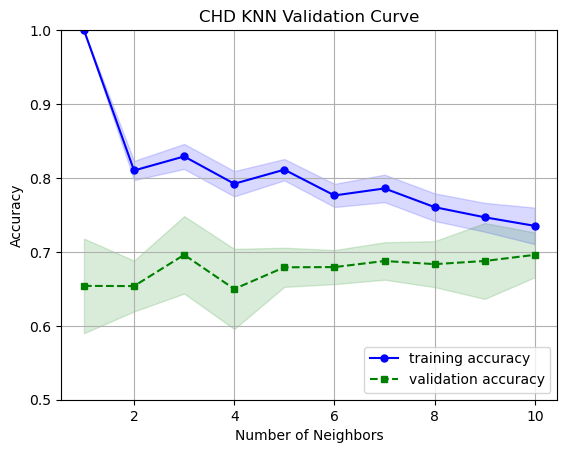

In [24]:
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('linear')
plt.legend(loc='lower right')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('CHD KNN Validation Curve')
plt.ylim([0.5, 1.0])
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

y_pred = best_model.best_estimator_.predict(X_test)
confmat = confusion_matrix(y_true=Y_test, y_pred=y_pred)
print(confmat)

[[22  8]
 [14 16]]


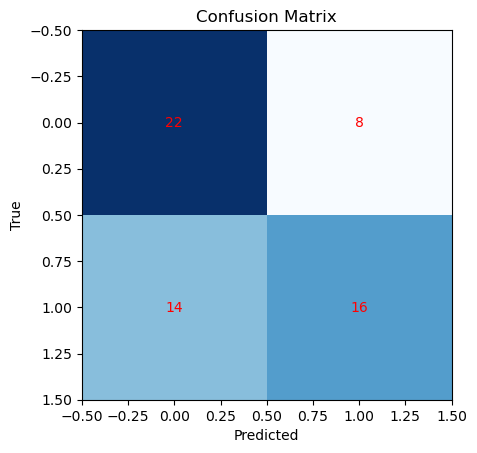

In [16]:
import matplotlib.pyplot as plt

# Plot the confusion matrix as an image
plt.imshow(confmat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Add the values as annotations
for i in range(2):
    for j in range(2):
        plt.text(j, i, confmat[i, j], ha='center', va='center', color='red')

# Show the plot
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=Y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=Y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=Y_test, y_pred=y_pred))

Precision: 0.667
Recall: 0.533
F1: 0.593


In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true=Y_test, y_score=y_pred, pos_label=1)
roc_auc = auc(x=fpr, y=tpr)
print('ROC AUC: %.3f' % roc_auc)

ROC AUC: 0.633


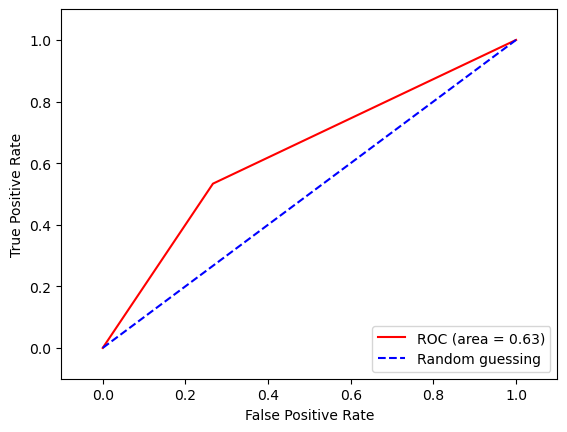

In [19]:
plt.plot(fpr, tpr, color='red', label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='blue', label='Random guessing')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [20]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score

scorer = make_scorer(accuracy_score)
scores = cross_val_score(estimator=best_model.best_estimator_, X=X_train, y=Y_train, cv=10, n_jobs=-1, scoring=scorer)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.91666667 0.625      0.79166667 0.66666667 0.625      0.70833333
 0.54166667 0.69565217 0.82608696 0.7826087 ]
CV accuracy: 0.718 +/- 0.106


/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packag

/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/lucmac/anaconda3/envs/asn1/lib/python3.10/site-packag

AttributeError: 'LearningCurveDisplay' object has no attribute 'show'

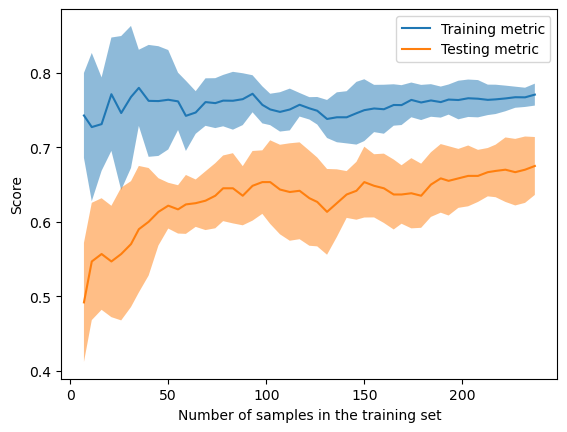

In [21]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
common_params = dict(X=predictors, y=target, cv=cv, scoring='accuracy', n_jobs=-1, score_type='both', train_sizes=np.linspace(0.01, 1.0, 50), verbose=0)
fit_params = {
    'estimator__n_neighbors': best_model.best_estimator_.get_params()['n_neighbors'],
    'estimator__weights': best_model.best_estimator_.get_params()['weights'],
    'estimator__metric': best_model.best_estimator_.get_params()['metric'],
    'estimator__algorithm': best_model.best_estimator_.get_params()['algorithm'],
    'estimator__leaf_size': best_model.best_estimator_.get_params()['leaf_size'],
    'estimator__p': best_model.best_estimator_.get_params()['p']
}
X, y = predictors, target
knn = KNeighborsClassifier()
viz = LearningCurveDisplay.from_estimator(knn, **common_params)
viz.show()